In [1]:
import bs4 as bs
import concurrent.futures
import datetime
from functools import partial
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import re
import time


###### Link to sample data on Google Drive

https://drive.google.com/file/d/1rAqpbo3z-pjUNZizY0qgvMSIezLX_xlC/view

# 1: Python Requests Library

### We use the Python 'requests' library to interact with the internet
###### Requests Docs: https://requests.kennethreitz.org/en/master/#
###### Requests Tutorial: https://realpython.com/python-requests/
###### Requests Youtube tutorial: https://www.youtube.com/watch?v=tb8gHvYlCFs

In [2]:
# makes a 'GET' request to the yahoo, should return '200'
# we can use 'response' to access all elements found in the page source
response = requests.get('https://finance.yahoo.com/quote/TSLA?p=TSLA', 'lxml')
# this should redurrn '<Response [200]>' indicating a succsesfulll request and response
print(response)

<Response [200]>


### '.text' method gives us the page source

In [3]:
# we are assigning text value of the reponse to variable 'response_text' 
response_text = response.text

# notices that requests returns the page as a 'str'
print(f'response_text type: {type(response_text)}')

# prints out a spacer, makes output more readable
print('–'*50)
# print out 
print(response_text)

response_text type: <class 'str'>
––––––––––––––––––––––––––––––––––––––––––––––––––
<!DOCTYPE html><html id="atomic" class="NoJs featurephone" lang="en-US"><head prefix="og: http://ogp.me/ns#"><script>window.performance && window.performance.mark && window.performance.mark('PageStart');</script><meta charset="utf-8"/><title>Tesla, Inc. (TSLA) Stock Price, Quote, History &amp; News</title><meta name="keywords" content="TSLA, Tesla, Inc., TSLA stock chart, Tesla, Inc. stock chart, stock chart, stocks, quotes, finance"/><meta http-equiv="x-dns-prefetch-control" content="on"/><meta property="twitter:dnt" content="on"/><meta property="fb:app_id" content="90376669494"/><meta name="theme-color" content="#400090"/><meta name="viewport" content="width=device-width, initial-scale=1"/><meta name="description" lang="en-US" content="Find the latest Tesla, Inc. (TSLA) stock quote, history, news and other vital information to help you with your stock trading and investing."/><meta name="oath:guce:co

### The 'beautifulsoup' module allows us to search the webpage by tag/selector
Beautiful Soup module allows us to search webpages based on their html tags, classes, or ids
###### BS Docs: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
###### BS Tutorial: https://www.digitalocean.com/community/tutorials/how-to-scrape-web-pages-with-beautiful-soup-and-python-3
###### BS Youtube Tutorial: https://www.youtube.com/watch?v=ng2o98k983k


In [4]:
# creates 'bs4.BeautifulSoup' Object
source = bs.BeautifulSoup(response_text)

# notices that 'source' type is a BeautifulSoup object, we can search this for specific elements
print('SOURCE TYPE:\n', type(source))

# spacer( '\n' means 'new line')
print('\n')

# prints out the page source as a string 'str'
print('SOURCE:\n', source)

SOURCE TYPE:
 <class 'bs4.BeautifulSoup'>


SOURCE:
 <!DOCTYPE html>
<html class="NoJs featurephone" id="atomic" lang="en-US"><head prefix="og: http://ogp.me/ns#"><script>window.performance && window.performance.mark && window.performance.mark('PageStart');</script><meta charset="utf-8"/><title>Tesla, Inc. (TSLA) Stock Price, Quote, History &amp; News</title><meta content="TSLA, Tesla, Inc., TSLA stock chart, Tesla, Inc. stock chart, stock chart, stocks, quotes, finance" name="keywords"/><meta content="on" http-equiv="x-dns-prefetch-control"/><meta content="on" property="twitter:dnt"/><meta content="90376669494" property="fb:app_id"/><meta content="#400090" name="theme-color"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="Find the latest Tesla, Inc. (TSLA) stock quote, history, news and other vital information to help you with your stock trading and investing." lang="en-US" name="description"/><meta content="guce.yahoo.com" name="oath:guce:consent-

##### Finda all links in the webage

In [5]:
# finds all elements with the 'a' tag
links = source.find_all('a')

# here we are 'itterating' over the 'list' of links, and printing out each 'link' in the list 
for link in links:
    
    # 'link' is any 'a' tag on the page source. This includes the url, its classes, ids and any other atributes 
    print('LINK:\n', link)

    # we are filtering link to just the 'href' atribute, this conatines the actual url
    print('URL:\n', link['href'])
    
    # print the text value of the link, this is what is displayed on the web page when you click on it
    print('TEXT:\n', link.text)
    
    # divider, makes output more readdable
    print("-"*100)

LINK:
 <a class="Bgpx(0) Bgr(nr) Cur(p) D(b) H(35px) Bgz(702px) Mx(a)! W(92px)" data-reactid="12" href="https://finance.yahoo.com/" id="uh-logo"><b class="Hidden" data-reactid="13">Yahoo</b></a>
URL:
 https://finance.yahoo.com/
TEXT:
 Yahoo
----------------------------------------------------------------------------------------------------
LINK:
 <a class="Pos(r) D(ib) Ta(s) Td(n):h" data-reactid="45" href="https://mail.yahoo.com/?.intl=us&amp;.lang=en-US&amp;.partner=none&amp;.src=finance" id="uh-mail"><svg class="Cur(p)" data-icon="NavMail" data-reactid="46" height="35" style="fill:#400090;stroke:#400090;stroke-width:0;vertical-align:bottom;" viewbox="0 0 512 512" width="30"><path d="M460.586 91.31H51.504c-10.738 0-19.46 8.72-19.46 19.477v40.088l224 104.03 224-104.03v-40.088c0-10.757-8.702-19.478-19.458-19.478M32.046 193.426V402.96c0 10.758 8.72 19.48 19.458 19.48h409.082c10.756 0 19.46-8.722 19.46-19.48V193.428l-224 102.327-224-102.327z" data-reactid="47"></path></svg><b class="Lh(u

# 2: Get Company Financial Data

In [6]:
# takes any ticker symbol and returns financial data as a dictionary (‘dict’)
# ':str' and '-->' are examples of function annotations. Can be accessed with '.__annotations__'
# annotations give usefull information about the function
def get_company_data(ticker: str) -> dict:
    # this is called a 'doc string', a brief description of the function. Can be accessed with '.__doc__'
    '''
    Takes any ticker symbol and returns financial data as a dict
    Parameters: A ticker symbol (str)
    Returns: A dict of financial data from Yahoo Finance
    '''
    
    # base url for yahoo financial stats
    url = f'https://finance.yahoo.com/quote/{ticker}/key-statistics?p={ticker}'
    
    # header passed request
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    # makes request 
    response = requests.get(url, 'lxml', headers=headers)

    # handles for bad url, response should be 200, anything else is an error
    if response.status_code != 200:
        return {'ticker': ticker, '!status': f'code {response.status_code}'}
    
    # main bs page object
    source = bs.BeautifulSoup(response.text)
    # find all 'section' tags with 'data-test' attribute of 'qsp-statistics'
    data = source.find('section', {'data-test':'qsp-statistics'})
    
    # handles for invalid ticker symbol, ".find()" returns "None" 
    if data == None:
        return {'ticker': ticker, '!status': 'data == None'}
    
    # finds the company name: Selects all 'div' elements with an id of "'id':'quote-header-info'"
    company_name = source.find('div', {'id':'quote-header-info'}).find('h1').text
    
    # creates a list of all 'tr'('table row') elements. Since we know we want all info in the tables,
    # this is a good way to select the data. Note 'find_all' returns a 'list' of elements
    rows = data.find_all('tr')

    # Python dictionary object. '!' take are sorted first alphabetically, keeps in first column
    info_dict = {'ticker': ticker, '!status': response.status_code, '!!company_name': company_name}
    
    # We are 'iterating' over the 'list' of 'tr' elements, selecting the category, and data value
    for row in rows:
        
        # 'td' (table data) tag. Think of this as a cell in the table. These tables have two columns, 
        # the first column is the category name, the second is the data value,
        # should returns a list with 2 elements
        data = row.find_all('td')
        
        # we create 'key' variable in used in our dictionary. This contains name of the category
        key = data[0].text.strip()
        
        # we create 'value' variable in used in our dictionary. This contains value of the category
        value = data[1].text.strip()
        
        # add the key and value to the dictionary we created. 
        info_dict[key] = value
        
    # function returns the dictionary, if we set a variable equal to this function,
    # that variable will be a dictionary ('dict' object)
    return info_dict
    

In [7]:
# function annotations
print(get_company_data.__annotations__)
# function doc string
print(get_company_data.__doc__)

{'ticker': <class 'str'>, 'return': <class 'dict'>}

    Takes any ticker symbol and returns financial data as a dict
    Parameters: A ticker symbol (str)
    Returns: A dict of financial data from Yahoo Finance
    


### We use the 'Pandas' (imported as 'pd') module to organize the data into a useable table
###### Pandas Docs: https://pandas.pydata.org/pandas-docs/stable/
###### Pandas Tutorial: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html
###### Pandas Youtube Tutorial: https://www.youtube.com/watch?v=0UA49Ds1XXo

In [8]:
# Python 'list' that containes three tickers ('str')
ticker_list = ['tsla', 'goog', 'gs', 'fb']

# an empty Python 'list'. This is used to store data temporaraly before being tunred into a Pandad 'DataFrame'
company_data_list = []

# we are 'itterating' over the 'ticker_list'
for ticker in ticker_list:
    
    # feeds each of the tickers in the list into the 'get_company_data' function we defined earlier
    # and asign the return value of this function ('dict') to a variable 'company_data'
    company_data = get_company_data(ticker)
    
    # adds the 'company_data' to the empty 'company_data_list' we created earlier
    company_data_list.append(company_data)
    
    print(ticker.upper())
    print(company_data_list)


TSLA
[{'ticker': 'tsla', '!status': 200, '!!company_name': 'TSLA - Tesla, Inc.', 'Market Cap (intraday) 5': '56.64B', 'Enterprise Value 3': '68.11B', 'Trailing P/E': 'N/A', 'Forward P/E 1': '65.07', 'PEG Ratio (5 yr expected) 1': '-1.60', 'Price/Sales (ttm)': '2.32', 'Price/Book (mrq)': '9.37', 'Enterprise Value/Revenue 3': '2.79', 'Enterprise Value/EBITDA 6': '30.78', 'Beta (3Y Monthly)': '0.32', '52-Week Change 3': '-2.85%', 'S&P500 52-Week Change 3': '12.08%', '52 Week High 3': '379.49', '52 Week Low 3': '176.99', '50-Day Moving Average 3': '250.63', '200-Day Moving Average 3': '234.91', 'Avg Vol (3 month) 3': '7.64M', 'Avg Vol (10 day) 3': '15.57M', 'Shares Outstanding 5': '179.13M', 'Float': '140.86M', '% Held by Insiders 1': '24.98%', '% Held by Institutions 1': '62.93%', 'Shares Short (Oct 15, 2019) 4': '37.19M', 'Short Ratio (Oct 15, 2019) 4': '4.78', 'Short % of Float (Oct 15, 2019) 4': '27.57%', 'Short % of Shares Outstanding (Oct 15, 2019) 4': '20.76%', 'Shares Short (prior 

FB
[{'ticker': 'tsla', '!status': 200, '!!company_name': 'TSLA - Tesla, Inc.', 'Market Cap (intraday) 5': '56.64B', 'Enterprise Value 3': '68.11B', 'Trailing P/E': 'N/A', 'Forward P/E 1': '65.07', 'PEG Ratio (5 yr expected) 1': '-1.60', 'Price/Sales (ttm)': '2.32', 'Price/Book (mrq)': '9.37', 'Enterprise Value/Revenue 3': '2.79', 'Enterprise Value/EBITDA 6': '30.78', 'Beta (3Y Monthly)': '0.32', '52-Week Change 3': '-2.85%', 'S&P500 52-Week Change 3': '12.08%', '52 Week High 3': '379.49', '52 Week Low 3': '176.99', '50-Day Moving Average 3': '250.63', '200-Day Moving Average 3': '234.91', 'Avg Vol (3 month) 3': '7.64M', 'Avg Vol (10 day) 3': '15.57M', 'Shares Outstanding 5': '179.13M', 'Float': '140.86M', '% Held by Insiders 1': '24.98%', '% Held by Institutions 1': '62.93%', 'Shares Short (Oct 15, 2019) 4': '37.19M', 'Short Ratio (Oct 15, 2019) 4': '4.78', 'Short % of Float (Oct 15, 2019) 4': '27.57%', 'Short % of Shares Outstanding (Oct 15, 2019) 4': '20.76%', 'Shares Short (prior mo

In [9]:
# variable 'df' is created, this will be our 'DataFrame'
# 'pd.DataFrame' is a pandas 'DataFrame' object. You can think of it  
# much like an excel spreadsheet (rows and columns)
# the dataframe is created by passing a 'list' of dictionaries ('dict') which pandas converts
df = pd.DataFrame(company_data_list)

# by default, pandas creates an numerical index (1,2,3...). We are setting the index to the 'ticker' column
df.set_index('ticker', inplace=True)

# shape give us the rows and columns of the 'df'
print(df.shape)

# jupyter will display the 'df' if it is the last line in a cell, without useing the 'print' function
df

(4, 61)


,!status,!!company_name,Market Cap (intraday) 5,Enterprise Value 3,Trailing P/E,Forward P/E 1,PEG Ratio (5 yr expected) 1,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue 3,...,Diluted EPS (ttm),Quarterly Earnings Growth (yoy),Total Cash (mrq),Total Cash Per Share (mrq),Total Debt (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Book Value Per Share (mrq),Operating Cash Flow (ttm),Levered Free Cash Flow (ttm)
ticker,,,,,,,,,,,,,,,,,,,,,
tsla,200,"TSLA - Tesla, Inc.",56.64B,68.11B,N/A,65.07,-1.60,2.32,9.37,2.79,...,-4.77,-54.10%,5.34B,29.82,13.34B,178.34,1.08,33.74,2.21B,1.28B
goog,200,GOOG - Alphabet Inc.,875.15B,789.36B,26.86,22.66,1.63,5.64,4.49,5.09,...,47.00,-23.10%,121.18B,174.31,13.75B,7.05,3.78,280.92,53.08B,21.37B
gs,200,"GS - The Goldman Sachs Group, Inc.",78.26B,-15.13B,9.73,9.03,2.40,2.32,1.00,-0.45,...,22.38,-25.60%,519B,"1,402.7",409B,444.57,2.72,218.37,N/A,N/A
fb,200,"FB - Facebook, Inc.",540.09B,499.96B,32.02,19.95,1.34,8.63,6.09,7.99,...,5.91,-48.80%,48.6B,17.03,8.2B,9.24,4.47,31.10,33.04B,13.64B


# 3: Get List of S&P 500 Tickers
###### Wikipedia list of S&P 500 Comapnies:  https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
###### Yahoo: https://finance.yahoo.com/quote/TSLA/key-statistics?p=TSLA

In [10]:
# creates a list of S&P 500 tickers from Wikipedia, returns dictionary of company ticker and name
# Note this function takes no parameters, the url is included in the function,
# will not work with other Wikipedia pages
def get_tickers() -> list:
    '''
    Parameters: None
    Returns: A list of dictionaries containing companies and their tickers
    '''
    # unlike the previous function the url is not going to change
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # optional headers, in this case we are changing the user agent
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    # request the Wikipedia page
    response = requests.get(url, 'lxml', headers=headers)
    
    # bs object, searchable by 'dom' elements
    source = bs.BeautifulSoup(response.text)  
    
    # find the first element with a 'table' tag, and a 'id' of 'constituents'
    main_table = source.find('table', {'id': 'constituents'})
    
    # after finding the 'main_table', we select just the table body 'tbody'
    table_body = main_table.find('tbody')
    
    # selects all rows 'tr' in the table body
    rows = table_body.find_all('tr')
    
    # each ticker is added to this list
    company_list = []
    # itterate over the table rows, select each ticker symbol
    for row in rows:
        
        # row contains list of 'td' (table data) elements
        row_cells = row.find_all('td')
        
        # skips any row missing essential data (first and second column)
        if len(row_cells) <= 1:
            # 'continue' advances the for loop to the next item
            continue
                
        # first column in table. '.strip' removes white space
        ticker = row_cells[0].text.strip()
        
        # '.append' method adds a element ('ticker') to the end of a list ([company_list').
        company_list.append(ticker)
        
    # return Python list containing all S&P 500 tickers  
    return company_list
              

##### Runs the 'get_tickers()' function, creates list of tickers

In [11]:
# creates a variable 'tickers_list' which is set equal to the output of 'get_tickers()' function
tickers_list = get_tickers()

# prints number of tickers in 'tickers_list'
print(f"{len(tickers_list)} tickers in list")

# prints the entire 'ticker_list'
print(tickers_list)

505 tickers in list
['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CDW', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW',

##### Gets financial data for the first 10 tickers

In [12]:
# gets data for first 10 on a single thread
# 't0' is start time
t0 = time.time()

# data for each company will be added to this list
company_data_list = []
# itterate over the first 10 tickers in the tickers list.
# '[:10]' is slice notation for first 10 elements in list
for ticker in tickers_list[:10]:
    
    # variable 'company_data' is set to the return value of 'get_company_data' function, a dictionary
    company_data = get_company_data(ticker)
    
    # add the company data dictionary to 'company_data_list'
    company_data_list.append(company_data)
    
    print(ticker)
    
# 't1' is current time when this line is evaluated
t1 = time.time()
print("{:.4} seconds".format(t1-t0))

# makes 'DataFrame' from 'company_data_list'
df = pd.DataFrame(company_data_list)

# set the ticker column as the index
df.set_index('ticker', inplace=True)

# df rows and columns
print(df.shape)

MMM
ABT
ABBV
ABMD
ACN
ATVI
ADBE
AMD
AAP
AES
6.412 seconds
(10, 61)


##### Prints the DataFrame

In [13]:
# df rows and columns
print(df.shape)

# prints df
df

(10, 61)


,!status,!!company_name,Market Cap (intraday) 5,Enterprise Value 3,Trailing P/E,Forward P/E 1,PEG Ratio (5 yr expected) 1,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue 3,...,Diluted EPS (ttm),Quarterly Earnings Growth (yoy),Total Cash (mrq),Total Cash Per Share (mrq),Total Debt (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Book Value Per Share (mrq),Operating Cash Flow (ttm),Levered Free Cash Flow (ttm)
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,200,MMM - 3M Company,97.07B,109.92B,20.02,17.30,13.98,3.04,9.07,3.44,...,8.43,2.60%,7.76B,13.5,20.4B,189.51,2.30,18.61,6.99B,4.61B
ABT,200,ABT - Abbott Laboratories,147.49B,162.99B,45.35,23.18,2.16,4.70,4.65,5.20,...,1.84,70.50%,3.38B,1.91,20.07B,62.92,N/A,17.93,N/A,N/A
ABBV,200,ABBV - AbbVie Inc.,116.02B,148.18B,28.65,8.21,1.92,3.56,N/A,4.54,...,2.74,-62.60%,5.42B,3.66,37.79B,N/A,0.89,-5.79,13.41B,9.81B
ABMD,200,"ABMD - Abiomed, Inc.",8.39B,7.87B,33.09,35.43,1.43,10.53,8.37,9.88,...,5.59,-1.30%,486.67M,10.73,13.66M,1.36,6.76,22.10,270.19M,146.02M
ACN,200,ACN - Accenture plc,117.7B,110.81B,25.11,21.54,2.70,2.72,8.17,2.56,...,7.36,9.80%,6.13B,9.62,22.66M,0.15,1.40,22.62,6.63B,5.42B
ATVI,200,"ATVI - Activision Blizzard, Inc.",41.42B,40.14B,24.66,21.34,4.41,5.82,3.46,5.64,...,2.19,-18.40%,4.67B,6.09,2.96B,24.73,3.45,15.62,1.86B,1.78B
ADBE,200,ADBE - Adobe Inc.,131.4B,131.84B,48.30,28.01,1.66,12.35,12.85,12.39,...,5.62,19.00%,3.65B,7.54,4.14B,40.39,0.74,21.12,4.15B,2.85B
AMD,200,"AMD - Advanced Micro Devices, Inc.",36.38B,36.72B,182.49,31.16,1.39,6.19,18.87,6.25,...,0.18,-69.80%,1.13B,1.04,1.28B,67.33,2.08,1.75,13M,-58.38M
AAP,200,"AAP - Advance Auto Parts, Inc.",11.73B,14.29B,27.44,18.20,1.15,1.21,3.19,1.48,...,5.99,5.90%,747.72M,10.53,3.23B,87.94,1.36,51.50,859.22M,526.88M


# 4: Saving Data
### convert the data to a CSV from the pandas DataFrame

In [14]:
# Current Working Directory. The current folder this file is in
print(os.getcwd())

/Users/garrettgilliom/Downloads/python_data_scraping-master 2


In [15]:
# all files in directory before making the csv, 'enumerate' function numbers what is being looped over
for index, file in enumerate(os.listdir()):
    print(index, file)

0 .ipynb_checkpoints
1 C&C_Data_Scraping.ipynb


In [16]:
# save as CSV (Comma Seperated Values)
df.to_csv(f'financial_data.csv')

# save a file with the current datetime to prevent overriding an existing file
df.to_csv(f'financial_data_{time.asctime()}.csv')


In [17]:
# all files in directory before making the csv
for index, file in enumerate(os.listdir()):
    print(index, file)

0 financial_data_Tue Oct 29 23:27:43 2019.csv
1 .ipynb_checkpoints
2 financial_data.csv
3 C&C_Data_Scraping.ipynb


In [18]:
# create DataFrame from CSV, setting the index collumn to the first (0th) column in the CSV
df2 = pd.read_csv('financial_data.csv', index_col=0)
df2

,!status,!!company_name,Market Cap (intraday) 5,Enterprise Value 3,Trailing P/E,Forward P/E 1,PEG Ratio (5 yr expected) 1,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue 3,...,Diluted EPS (ttm),Quarterly Earnings Growth (yoy),Total Cash (mrq),Total Cash Per Share (mrq),Total Debt (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Book Value Per Share (mrq),Operating Cash Flow (ttm),Levered Free Cash Flow (ttm)
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,200,MMM - 3M Company,97.07B,109.92B,20.02,17.30,13.98,3.04,9.07,3.44,...,8.43,2.60%,7.76B,13.50,20.4B,189.51,2.30,18.61,6.99B,4.61B
ABT,200,ABT - Abbott Laboratories,147.49B,162.99B,45.35,23.18,2.16,4.70,4.65,5.20,...,1.84,70.50%,3.38B,1.91,20.07B,62.92,NaN,17.93,NaN,NaN
ABBV,200,ABBV - AbbVie Inc.,116.02B,148.18B,28.65,8.21,1.92,3.56,NaN,4.54,...,2.74,-62.60%,5.42B,3.66,37.79B,NaN,0.89,-5.79,13.41B,9.81B
ABMD,200,"ABMD - Abiomed, Inc.",8.39B,7.87B,33.09,35.43,1.43,10.53,8.37,9.88,...,5.59,-1.30%,486.67M,10.73,13.66M,1.36,6.76,22.10,270.19M,146.02M
ACN,200,ACN - Accenture plc,117.7B,110.81B,25.11,21.54,2.70,2.72,8.17,2.56,...,7.36,9.80%,6.13B,9.62,22.66M,0.15,1.40,22.62,6.63B,5.42B
ATVI,200,"ATVI - Activision Blizzard, Inc.",41.42B,40.14B,24.66,21.34,4.41,5.82,3.46,5.64,...,2.19,-18.40%,4.67B,6.09,2.96B,24.73,3.45,15.62,1.86B,1.78B
ADBE,200,ADBE - Adobe Inc.,131.4B,131.84B,48.30,28.01,1.66,12.35,12.85,12.39,...,5.62,19.00%,3.65B,7.54,4.14B,40.39,0.74,21.12,4.15B,2.85B
AMD,200,"AMD - Advanced Micro Devices, Inc.",36.38B,36.72B,182.49,31.16,1.39,6.19,18.87,6.25,...,0.18,-69.80%,1.13B,1.04,1.28B,67.33,2.08,1.75,13M,-58.38M
AAP,200,"AAP - Advance Auto Parts, Inc.",11.73B,14.29B,27.44,18.20,1.15,1.21,3.19,1.48,...,5.99,5.90%,747.72M,10.53,3.23B,87.94,1.36,51.50,859.22M,526.88M


# 5: Multithread Requests (Thread pool executor)
### Request multiple pages at once, saves time

In [19]:
# re run 'get_tickers()'
tickers_list = get_tickers()
print(f"{len(tickers_list)} tickers in list")

505 tickers in list


#####  'thread_function ' makes multiple requests at once

In [20]:
# asynchronously call "get_company_data". Acts as a 'wrapper' for the other functions
def thread_function(num, input_ticker_list=tickers_list, get_company_data_function=get_company_data) -> None:
    
    # ticker at index in list (num=5, 4th ticker in list, staring at 0)
    ticker = input_ticker_list[num]
    
    # calls company data function
    company_data = get_company_data_function(ticker)
   
    # adds 'compnay_data' to shared list
    company_data_list.append(company_data)
    

##### Runs 'thread_function' with 'tickers_list'

In [21]:
# start time
t0 = time.time()

# 'list' of dictionaries 'dict'
company_data_list = []

# max workers = max number of threads to be open at any one time
# 'multithread' the requests. This means we are makeing multiple requests at once.
# 'max_workers=5' is the max number of threads we can have open at ay one time.
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:

    # 'mapping' the function to a range of integers. Eaxh 'int' corasponds to a index in the list
    # 'partial' function allows us to pass one parameter to the functin before mapping it 
    executor.map(thread_function, range(10))

# create the 'DataFrame'
df = pd.DataFrame(company_data_list)
df.set_index('ticker', inplace=True)


# end time
t1 = time.time()
# prints time it took for this cell to execute
print("{:.4} seconds".format(t1-t0))
print(df.shape)

1.881 seconds
(10, 61)


In [22]:
print(df.shape)
df

(10, 61)


,!status,!!company_name,Market Cap (intraday) 5,Enterprise Value 3,Trailing P/E,Forward P/E 1,PEG Ratio (5 yr expected) 1,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue 3,...,Diluted EPS (ttm),Quarterly Earnings Growth (yoy),Total Cash (mrq),Total Cash Per Share (mrq),Total Debt (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Book Value Per Share (mrq),Operating Cash Flow (ttm),Levered Free Cash Flow (ttm)
ticker,,,,,,,,,,,,,,,,,,,,,
ABMD,200,"ABMD - Abiomed, Inc.",8.39B,7.87B,33.09,35.43,1.43,10.53,8.37,9.88,...,5.59,-1.30%,486.67M,10.73,13.66M,1.36,6.76,22.10,270.19M,146.02M
ABT,200,ABT - Abbott Laboratories,147.49B,162.99B,45.35,23.18,2.16,4.70,4.65,5.20,...,1.84,70.50%,3.38B,1.91,20.07B,62.92,N/A,17.93,N/A,N/A
ACN,200,ACN - Accenture plc,117.7B,110.81B,25.11,21.54,2.70,2.72,8.17,2.56,...,7.36,9.80%,6.13B,9.62,22.66M,0.15,1.40,22.62,6.63B,5.42B
ABBV,200,ABBV - AbbVie Inc.,116.02B,148.18B,28.65,8.21,1.92,3.56,N/A,4.54,...,2.74,-62.60%,5.42B,3.66,37.79B,N/A,0.89,-5.79,13.41B,9.81B
MMM,200,MMM - 3M Company,97.07B,109.92B,20.02,17.30,13.98,3.04,9.07,3.44,...,8.43,2.60%,7.76B,13.5,20.4B,189.51,2.30,18.61,6.99B,4.61B
AES,200,AES - The AES Corporation,11.35B,32.05B,28.48,11.87,1.36,1.07,3.54,3.03,...,0.60,-94.10%,1.58B,2.38,20.03B,362.41,1.37,4.83,2.39B,-915M
AMD,200,"AMD - Advanced Micro Devices, Inc.",36.38B,36.72B,182.49,31.16,1.39,6.19,18.87,6.25,...,0.18,-69.80%,1.13B,1.04,1.28B,67.33,2.08,1.75,13M,-58.38M
ATVI,200,"ATVI - Activision Blizzard, Inc.",41.42B,40.14B,24.66,21.34,4.41,5.82,3.46,5.64,...,2.19,-18.40%,4.67B,6.09,2.96B,24.73,3.45,15.62,1.86B,1.78B
ADBE,200,ADBE - Adobe Inc.,131.4B,131.84B,48.30,28.01,1.66,12.35,12.85,12.39,...,5.62,19.00%,3.65B,7.54,4.14B,40.39,0.74,21.12,4.15B,2.85B


#### filters the 'tickers_list' based on starting letter

In [23]:
# filters 'tickers_list' for tickers that start with given letter. * = 'args' = multiple arguments
def starts_with(*letters, tickers_list=tickers_list): 
    
    filtered_tickers = []
    
    for letter in letters:
        filtered_tickers.extend([ticker for ticker in tickers_list if ticker.startswith(letter.upper())])  
    return filtered_tickers

letter_1 = 's'
letter_2 = 't'
letter_3 = 'r'

letter_list = starts_with(letter_1, letter_2, letter_3)

print(len(letter_list))
print(letter_list)



60
['SCHW', 'STZ', 'SJM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'SPGI', 'SWK', 'SBUX', 'STT', 'SYK', 'STI', 'SIVB', 'SYMC', 'SYF', 'SNPS', 'SYY', 'T', 'TAP', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TFX', 'TXN', 'TXT', 'TMO', 'TIF', 'TWTR', 'TJX', 'TSCO', 'TDG', 'TRV', 'TRIP', 'TSN', 'RE', 'RL', 'RJF', 'RTN', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL']


In [24]:
# 'list' of dictionaries 'dict'
company_data_list = []

# max workers = max number of threads to be open at any one time
# 'multithread' the requests. This means we are makeing multiple requests at once.
# 'max_workers=5' is the max number of threads we can have open at ay one time.
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:

    # 'mapping' the function to a range of integers. Eaxh 'int' corasponds to a index in the list
    # 'partial' function allows us to pass one parameter to the functin before mapping it 
    executor.map(partial(thread_function, input_ticker_list=letter_list), range(len(letter_list)))

# create the data frame
df = pd.DataFrame(company_data_list)
df.set_index('ticker', inplace=True)

print(df.shape)

(60, 61)


In [25]:
df1 = df[df.index.str.startswith(letter_1.upper())]
df2 = df[df.index.str.startswith(letter_2.upper())]
df3 = df[df.index.str.startswith(letter_3.upper())]

In [26]:
print(df1.head().index)
print(df2.head().index)
print(df3.head().index)

Index(['SLB', 'SCHW', 'SBAC', 'STZ', 'SJM'], dtype='object', name='ticker')
Index(['T', 'TAP', 'TMUS', 'TTWO', 'TROW'], dtype='object', name='ticker')
Index(['RE', 'RL', 'RTN', 'RJF', 'REGN'], dtype='object', name='ticker')


In [27]:
df3['Profit Margin']

ticker
RE       5.39%
RL       6.91%
RTN     11.47%
RJF     13.40%
REGN    28.59%
REG     24.93%
RF      29.44%
RMD     15.52%
RSG     10.32%
ROK     15.44%
RHI      7.56%
ROL     10.42%
ROST    10.46%
RCL     17.82%
ROP     21.58%
Name: Profit Margin, dtype: object

In [28]:
# print(df["Profit Margin "])
df['PM_num'] = df['Profit Margin'].str.replace('%','') 

In [29]:
df['PM_num']

ticker
SLB     -30.22
SCHW     35.12
SBAC      6.89
STZ       9.40
SJM       6.95
STX      19.36
SEE       7.84
SPG      41.10
SHW       7.81
SRE      17.15
SWKS     26.10
SLG      16.63
SNA      17.17
SPGI     31.02
SO       20.10
SWK       4.53
SBUX     13.63
STT      18.34
SYK      24.99
STI      28.65
SYMC      2.43
SYY       2.79
SIVB     37.15
SNPS     18.94
SYF      41.19
T         8.98
TAP       8.44
TMUS      7.53
TTWO     10.93
TROW     35.53
TPR      10.68
TGT       4.10
TEL      22.94
TFX      10.78
TXN      35.16
TXT       6.46
TMO      14.24
TIF      12.79
TWTR     47.67
TJX       7.65
TSCO      6.69
TRV       7.57
TDG      15.76
TRIP      8.55
RE        5.39
TSN       5.27
RL        6.91
RTN      11.47
RJF      13.40
REGN     28.59
REG      24.93
RF       29.44
RMD      15.52
RSG      10.32
ROK      15.44
RHI       7.56
ROL      10.42
ROST     10.46
RCL      17.82
ROP      21.58
Name: PM_num, dtype: object

In [34]:

def get_pm(df):
    profit_margins = []
    for ticker in df['Profit Margin']:
        if type(ticker) == float or ('%' not in ticker): 
            continue
        pm = float(ticker.replace('%',''))
        profit_margins.append(pm)

    return sum(profit_margins)/len(profit_margins)

get_pm(df)

15.700500000000002

# 6: Visualize Data

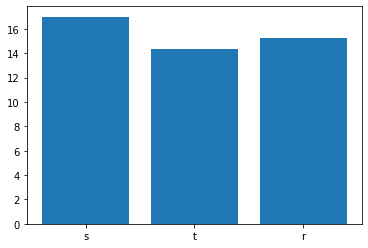

In [35]:
y = [get_pm(df1), get_pm(df2), get_pm(df3)]
x = [letter_1, letter_2, letter_3]

plt.bar(x,y)
plt.show()

In [40]:
# x values
labels = []
# y values
values = []
profit_margins = []

for index, row in df1.iterrows():
    pm = row['Profit Margin']
        
    if type(pm) == float or ('%' not in pm): 
        continue

    pm = float(pm.replace('%',''))
    profit_margins.append(pm)

    labels.append(index)
    values.append(pm)


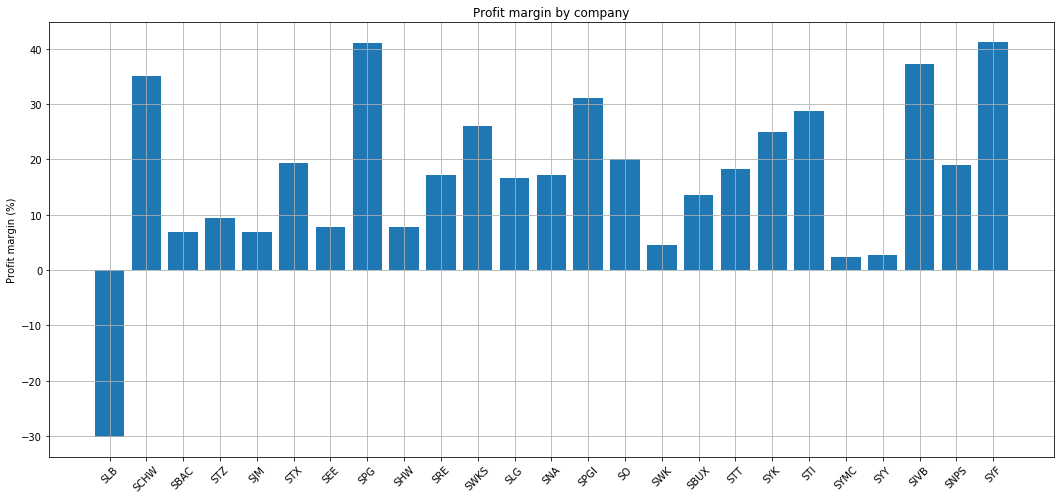

In [41]:

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)

ax.bar(labels, values)

plt.xticks(rotation=45)
plt.ylabel('Profit margin (%)')
plt.title('Profit margin by company')

plt.grid()

# WSJ Headline Word Frequency

In [43]:
# read in the saved csv files
files = os.listdir(os.path.join(os.getcwd(), 'wsj_csvs'))

file_list = []
for file in files:
    f = file.strip('.csv')
    if f != "DS_Store":
        file_list.append(f)
        
print(len(file_list))
print(min(file_list))   
print(max(file_list))      

3601
20091215
20191029


In [44]:
# create a list of pandas DataFrames from the WSJ CSVs
df_list = []
for file in files[:]:
    df_list.append(pd.read_csv(f"wsj_csvs/{file}", index_col=0))
print(len(df_list))


3602


In [45]:
# create a master DataFrame with every wsj_csv
df = pd.concat(df_list)
df.reset_index(inplace=True, drop=True)

df['date'] = pd.to_datetime(df['date'].copy(), format='%Y%m%d')
df.set_index('date', inplace=True, drop=True)
df.sort_index()
df['count'] = 1
df

,section,headline,summary,count
date,,,,
2014-05-01,Opinion,Pepper...and Salt,Pepper...and Salt,1
2014-05-01,Deco Summary (Plain),Will China's Economy Surpass the U.S.?,News China's economy could overtake the U.S.'s...,1
2014-05-01,Whats News World Wide,What's News: World-Wide,What's News: World-Wide,1
2014-05-01,Opera,60 Seconds With Pierre Audi,Dutch National Opera artistic director Pierre ...,1
2014-05-01,Europe Off Duty,Big Small Talk: May 2-9,"Beatlemania, tattoos in Paris, Shakespeare in ...",1
...,...,...,...,...
2010-12-22,Business,Deutsche Settles U.S. Tax Case,Deutsche Bank agreed to pay $553.6 million and...,1
2010-12-22,Economy,U.K.'s Public Borrowing Surges,The U.K. prime minister said the country's eco...,1
2010-12-22,The Property Report,Grubb Ruling Offers Peek Into Boom Fallout,The case is one of a number alleging fraud and...,1


In [102]:
keyword_one = 'Apple'
keyword_two = 'Orange'
frequency = '14D'
window = 4
# df = df.loc['2012-01-01':'2019-10-24']

# keyword one
df_1 = df[
    df['summary'].str.contains(keyword_one) | 
    df['headline'].str.contains(keyword_one)
].copy()
df_1_re = pd.DataFrame(df_1['count'].resample(frequency).sum())
df_1_re['SMA'] = df_1_re['count'].rolling(window=window).mean()

# keyword two
df_2 = df[
    df['summary'].str.contains(keyword_two) |
    df['headline'].str.contains(keyword_two)
].copy()
df_2_re = pd.DataFrame(df_2['count'].resample(frequency).sum())
df_2_re['SMA'] = df_2_re['count'].rolling(window=window).mean()

print(len(df_1))
print(len(df_2))

3053
292


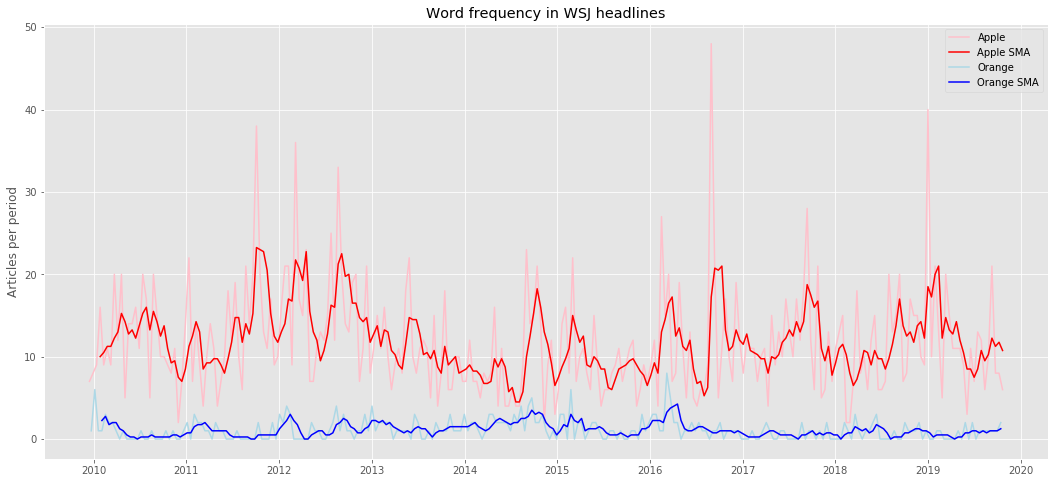

In [103]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)

plt.plot(df_1_re['count'], color='pink')
plt.plot(df_1_re['SMA'], color='red')

plt.plot(df_2_re['count'], color='lightblue')
plt.plot(df_2_re['SMA'], color='blue')

plt.legend((keyword_one, keyword_one+' SMA', keyword_two, keyword_two+' SMA'))

plt.xticks(rotation=0)
plt.ylabel('Articles per period')
plt.title('Word frequency in WSJ headlines')
plt.style.use('ggplot')
plt.show()

# NOTE: Following sections will NOT work with Anaconda alone

# 7: Using An In Memory Data Base (Redis)

In [50]:
import redis

ModuleNotFoundError: No module named 'redis'

In [ ]:
# must start redis server in terminal first
r_db = redis.Redis(port=6377, db=0)

In [ ]:
# set a key value pair 'name' : 'Stefan'
r_db.mset({"name": "Stefan"})

In [ ]:
# key value from db
r_db.mget('name')[0].decode('UTF-8')

In [ ]:
# clearS db
r_db.flushall()

In [ ]:
print(f"{len(tickers_list)} tickers in list")

In [ ]:
# asynchronously call "get_company_data"
def thread_map(num, input_tickers_list=tickers_list, get_company_data_function=get_company_data):
    # ticker at point in list
    ticker = input_tickers_list[num]
    # calls company data function
    company_data = get_company_data_function(ticker)
    r_db.mset({ticker: str(company_data)})
    

In [ ]:
t0 = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(thread_map, range(40))
        
t1 = time.time()
print("{:.4} seconds".format(t1-t0))


In [ ]:
# create datadrame from data in redis db
df = pd.DataFrame([json.loads(r_db.get(ticker).decode('UTF-8').replace("'",'"')) for ticker in r_db.keys()]).set_index('ticker')

print(f"{len(df.index)} Rows, {len(df.columns)} Columns")
df

# Common issues
### Somtimes content on a webpage wont apear in the 'requests' response

In [ ]:
response = requests.get('https://www.wsj.com/news/archive/20041001', 'lxml')

In [ ]:
source = bs.BeautifulSoup(response.text)
# fine all elements with an article tag
articles = source.find_all('article')
print(len(articles))
for article in articles:
    print(article.text)
    print('-'*30)

# 8: Selenium (render full web page before extracting data)

In [ ]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
import datetime
import getpass

In [ ]:
# define webdriver use firefox browser
options = Options()
# run without broswer window
#options.add_argument('--headless')
driver = webdriver.Firefox(options=options)

In [ ]:
driver.get('https://www.wsj.com/news/archive/20080608')

### Get newspaper title and article summary from WSJ archives

In [51]:
# creates a list of dates for wsj archive url
def create_date() -> list:
    start_date = datetime.date(1996, 4, 6)
    dates_list = []
    while True:
        start_date += datetime.timedelta(days=1)
        dates_list.append(str(start_date).replace('-',''))
        if datetime.date.today() == start_date:
            break
    return dates_list


In [52]:
# list list of possible dates fro url
dates = create_date()
print(f"{len(dates)} total dates")
print(dates[1:3],dates[-3:-1])

8606 total dates
['19960408', '19960409'] ['20191027', '20191028']


In [53]:
# current directory
print(os.listdir())

['.DS_Store', 'financial_data_Tue Oct 29 23:27:43 2019.csv', 'wsj_csvs', '.ipynb_checkpoints', 'financial_data.csv', 'C&C_Data_Scraping.ipynb']


In [54]:
csvs_folder = 'wsj_csvs2'
errors_folder = 'wsj_errors2'

In [55]:
# makes directory for each days csvs
if not os.path.exists(csvs_folder):
    os.mkdir(csvs_folder)
print(os.listdir())

['.DS_Store', 'wsj_csvs2', 'financial_data_Tue Oct 29 23:27:43 2019.csv', 'wsj_csvs', '.ipynb_checkpoints', 'financial_data.csv', 'C&C_Data_Scraping.ipynb']


In [56]:
# makes errors directory for each days csvs
if not os.path.exists(errors_folder):
    os.mkdir(errors_folder)
print(os.listdir())

['.DS_Store', 'wsj_csvs2', 'financial_data_Tue Oct 29 23:27:43 2019.csv', 'wsj_csvs', 'wsj_errors2', '.ipynb_checkpoints', 'financial_data.csv', 'C&C_Data_Scraping.ipynb']


In [57]:
# takes a formatted date, appends to WSJ archive url, returns df of days articles
def get_days_news(date):

    driver.get(f'https://www.wsj.com/news/archive/{date}')
    raw_source = driver.page_source
    source = bs.BeautifulSoup(raw_source)
    articles = source.select("article[class*='WSJTheme--story']")
    
    # if page does not load, date is added to error file
    timeout = 0
    # while article length is 0, the page waits until 
    while len(articles) == 0:
        # brief pause, allows page to coninue loading
        time.sleep(1)
        # redifine the page source
        raw_source = driver.page_source
        # redifine Beautifule soup
        source = bs.BeautifulSoup(raw_source)
        articles = source.select("article[class*='WSJTheme--story']")
        timeout += 1
        if timeout >= 20:
            with open(os.path.join(os.getcwd(), errors_folder, f"{date}.txt"),'w') as f:
                f.write(date)
            return
    
    time.sleep(1)
        
    dict_list = []
    for article in articles:
        #print(article.text)
        
        # the tree sections of each article row
        days_articles = {'section': article.select("div[class*='WSJTheme--flashline']"),
                         'headline': article.select("h3[class*='WSJTheme--headline']"), 
                         'summary': article.select("p[class*='WSJTheme--summary']")
                        }
        
        # adds each of the three sections to dict, used for df
        for item in days_articles:
            if days_articles[item] == []:
                days_articles[item] = 'None'
            else:
                days_articles[item] = days_articles[item][0].text
         
        # for date columns
        days_articles['date'] = date
        
        # add to 'dict_list'
        dict_list.append(days_articles)
    
    # creates pandas df from list of article dicts
    df = pd.DataFrame(dict_list)
    
    # add to csv
    df.to_csv(os.path.join(os.getcwd(), csvs_folder, f"{date}.csv"))
    
    return df
 

In [58]:
for index, date in enumerate(dates[1000:1005]):
    get_days_news(date)
    time.sleep(2)
    print(index, date) 

NameError: name 'driver' is not defined

# Reddit

In [59]:
# define webdriver use firefox browser
options = Options()
# run without broswer window
#options.add_argument('--headless')
driver = webdriver.Firefox(options=options)

NameError: name 'Options' is not defined

In [ ]:
driver.get('https://www.reddit.com')

In [ ]:
# get all images on page
def get_img_links(num):
    images = []
    while len(images) < num:
        raw_source = driver.page_source
        source = bs.BeautifulSoup(raw_source)
        images = source.select("img[class*='ImageBox-image'][class*='media-element']")
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        time.sleep(.5)
        print(len(images))
    return [image['src'] for image in images]

In [ ]:
# save img to disk
def save_img(url):
    split_url = (url.split('?')[0]).split('.')
    ext = split_url[-1]
    name = split_url[-2].split('/')[1]
    response = requests.get(url, stream=True)
    path = 'images'
    if not os.path.exists(path):
        os.mkdir(path)
    with open(f'{path}/{name}.{ext}', 'wb') as image_file:
        image_file.write(response.content)
    return name

In [ ]:
# creats list of all urls on the a redit page
image_urls = get_img_links(40)

In [ ]:
for image_url in image_urls:
    save_img(image_url)
    print(image_url)

# Youtube

In [ ]:
driver.get('https://accounts.google.com/signin/v2/identifier?service=youtube&uilel=3&passive=true&continue=https%3A%2F%2Fwww.youtube.com%2Fsignin%3Faction_handle_signin%3Dtrue%26app%3Ddesktop%26hl%3Den%26next%3D%252F&hl=en&ec=65620&flowName=GlifWebSignIn&flowEntry=ServiceLogin')

In [ ]:
# username/ password inputs
username_input = driver.find_element_by_id('identifierId')
username = getpass.getpass(prompt='Username', stream=None)
username_input.clear()
username_input.send_keys(username)
submit = driver.find_element_by_id("identifierNext")
submit.click()


In [ ]:
password_input = driver.find_element_by_xpath("//input[@type='password']")
password = getpass.getpass(prompt='Password', stream=None)
password_input.clear()
password_input.send_keys(password)
time.sleep(1)
submit = driver.find_element_by_id("passwordNext")
submit.click()

In [ ]:
driver.get('https://www.youtube.com/feed/trending?gl=US')

In [ ]:
source = bs.BeautifulSoup(driver.page_source)

In [ ]:
titles = source.select("a[id='video-title'][class*='ytd-video-renderer'][aria-label*='']")
print(len(titles))
for i in titles:
    print (i['href'])

In [ ]:
for title in titles[0:5]:
    rel_link = title['href']
    link = f'https://www.youtube.com{rel_link}'
    driver.get(link)
    time.sleep(.5)
    buttons = []
    timeout = 0
    while len(buttons) == 0:
        buttons = driver.find_elements_by_xpath("//button[starts-with(@aria-label,'like this')]")
        print(buttons)
        timeout += 1
        if timeout == 5:
            break
        time.sleep(.5)
    
    buttons[0].click()
    time.sleep(1)
    buttons[0].click()
    print(link)
    print('-----------')

In [ ]:
# makes csv from wikipedia
resp = requests.get('https://en.wikipedia.org/wiki/List_of_largest_companies_by_revenue', 'lxml')
source = bs.BeautifulSoup(resp.text)
table = source.select("table[class*='wikitable'][class*='wikitable']")[0]
rows = table.find_all('tr')
header = table.find_all('th')    
dict_list = []
for row in rows:
    data_dict = {}
    tds = row.find_all(['td', 'th'])
    for i, td in enumerate(tds):
        data_dict[header[i].text.strip()] = td.text.strip()
        
    print(data_dict)
    dict_list.append(data_dict)
    
df = pd.DataFrame(dict_list)
df.set_index('Rank')
df.to_csv('company_data.csv')    